In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

path_to_zip = tf.keras.utils.get_file( 'cornell_movie_dialogs.zip',
                                    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
                                    extract=True)

path_to_dataset = os.path.join( os.path.dirname(path_to_zip), "cornell movie-dialogs corpus" )

path_to_movie_lines = os.path.join( path_to_dataset, 'movie_lines.txt' )

path_to_movie_conversations = os.path.join( path_to_dataset,'movie_conversations.txt' )

9928704/9916637 [==============================] - 1s 0us/step


In [27]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000

In [28]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이 student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub( r"([?.!,])", r" \1 ", sentence )
  sentence = re.sub( r'[" "]+', " ", sentence )

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub( r"[^a-zA-Z?.!,]+", " ", sentence )
  sentence = sentence.strip()
  return sentence

In [29]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  id2line = {}

  with open( path_to_movie_lines, errors='ignore' ) as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]
  inputs, outputs = [], []

  with open( path_to_movie_conversations, 'r' ) as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용
      inputs.append( preprocess_sentence(id2line[conversation[i]]) )
      outputs.append( preprocess_sentence(id2line[conversation[i + 1]]) )

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

In [30]:
questions, answers = load_conversations()
print('질문 샘플 수 :', len(questions))
print('답변 샘플 수 :', len(answers))

질문 샘플 수 : 50000
답변 샘플 수 : 50000


In [31]:
print(questions[21])
print(answers[21])

she s not a . . .
lesbian ? no . i found a picture of jared leto in one of her drawers , so i m pretty sure she s not harboring same sex tendencies .


## 1. 단어장(Vocabulary) 만들기

In [32]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [33]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [34]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8331]
END_TOKEN의 번호 : [8332]


In [35]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8333


## 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [36]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [60, 8, 37, 8172, 49]
정수 인코딩 후의 21번째 답변 샘플: [7824, 1223, 19, 61, 2, 4, 336, 10, 1595, 14, 1104, 698, 3263, 263, 16, 71, 14, 107, 2133, 900, 3, 59, 4, 23, 355, 204, 60, 8, 37, 885, 2289, 8107, 344, 1001, 5179, 4214, 342, 1]


In [37]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

In [38]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences( tokenized_inputs, maxlen=MAX_LENGTH, padding='post' )
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences( tokenized_outputs, maxlen=MAX_LENGTH, padding='post' )
  return tokenized_inputs, tokenized_outputs

In [39]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8333
필터링 후의 질문 샘플 개수: 44095
필터링 후의 답변 샘플 개수: 44095


## 3. 교사 강요(Teacher Forcing) 사용하기

In [40]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 4. 모델 정의 및 학습하기

In [52]:
def transformer( vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer" ):
  inputs = tf.keras.Input( shape=(None,), name="inputs" )
  dec_inputs = tf.keras.Input( shape=(None,), name="dec_inputs" )

    
def create_padding_mask(x):
  mask = tf.cast( tf.math.equal( x, 0 ), tf.float32 )
       # (batch_size, 1, 1, sequence length)
  return mask[ :, tf.newaxis, tf.newaxis, : ]

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part( tf.ones( (seq_len, seq_len) ), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum( look_ahead_mask, padding_mask )

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda( create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
  
  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  dec_padding_mask = tf.keras.layers.Lambda( create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크하기 위해서 사용
  look_ahead_mask = tf.keras.layers.Lambda( create_look_ahead_mask, output_shape=(1, None, None),name='look_ahead_mask' )(dec_inputs)

  # 인코더
  enc_outputs = encoder(
              vocab_size=vocab_size,
              num_layers=num_layers,
              units=units,
              d_model=d_model,
              num_heads=num_heads,
              dropout=dropout,
              )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
              vocab_size=vocab_size,
              num_layers=num_layers,
              units=units,
              d_model=d_model,
              num_heads=num_heads,
              dropout=dropout,
          )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense( units=vocab_size, name="outputs" )(dec_outputs)

  return tf.keras.Model( inputs=[inputs, dec_inputs], outputs=outputs, name=name )

In [53]:
# 모델 생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2  # 인코더와 디코더의 층의 개수
D_MODEL = 256  # 인코더와 디코더 내부의 입출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512   # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [54]:
# 손실 함수(Loss function)
def loss_function( y_true, y_pred ):
  y_true = tf.reshape( y_true, shape=(-1, MAX_LENGTH - 1) )
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast( tf.not_equal(y_true, 0), tf.float32 )
  loss = tf.multiply( loss, mask )

  return tf.reduce_mean(loss)

In [55]:
# 커스텀 된 학습률(Learning rate)
class CustomSchedule( tf.keras.optimizers.schedules.LearningRateSchedule ):

  def __init__( self, d_model, warmup_steps=4000 ):
    super( CustomSchedule, self ).__init__()

    self.d_model = d_model
    self.d_model = tf.cast( self.d_model, tf.float32 )
    self.warmup_steps = warmup_steps

  def __call__( self, step ):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * ( self.warmup_steps**-1.5 )

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

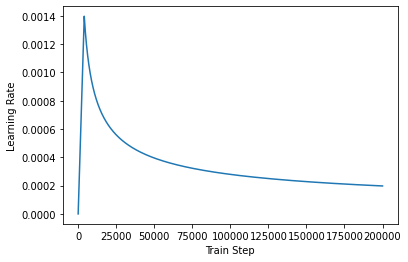

In [56]:
sample_learning_rate = CustomSchedule( d_model=128 )

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
# 훈련하기
EPOCHS = 1
model.fit(dataset, epochs=EPOCHS, verbose=1)

## 5. 챗봇 테스트하기

In [1]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims( START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0 )

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims( START_TOKEN, 0 )

  # 디코더의 인퍼런스 단계
  for i in range( MAX_LENGTH ):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model( inputs=[sentence, output_sequence], training=False )
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast( tf.argmax(predictions, axis=-1), tf.int32 )

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal( predicted_id, END_TOKEN[0] ):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat( [output_sequence, predicted_id], axis=-1 )

  return tf.squeeze( output_sequence, axis=0 )

In [2]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode( [i for i in prediction if i < tokenizer.vocab_size] )

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
sentence_generation('Where have you been?')

In [ ]:
sentence_generation("It's a trap")